QR code saved as data/qr/phase_qr_code.tif
QR code saved as data/qr/abs_qr_code.tif


/data/hereon/wp/user/hailudaw/mamba/envs/smrl/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1739249442529/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Stage 897  LR  score: 100%|██████████| 600/600 [04:30<00:00,  2.22it/s, psnr=54.433, ssim=0.999]


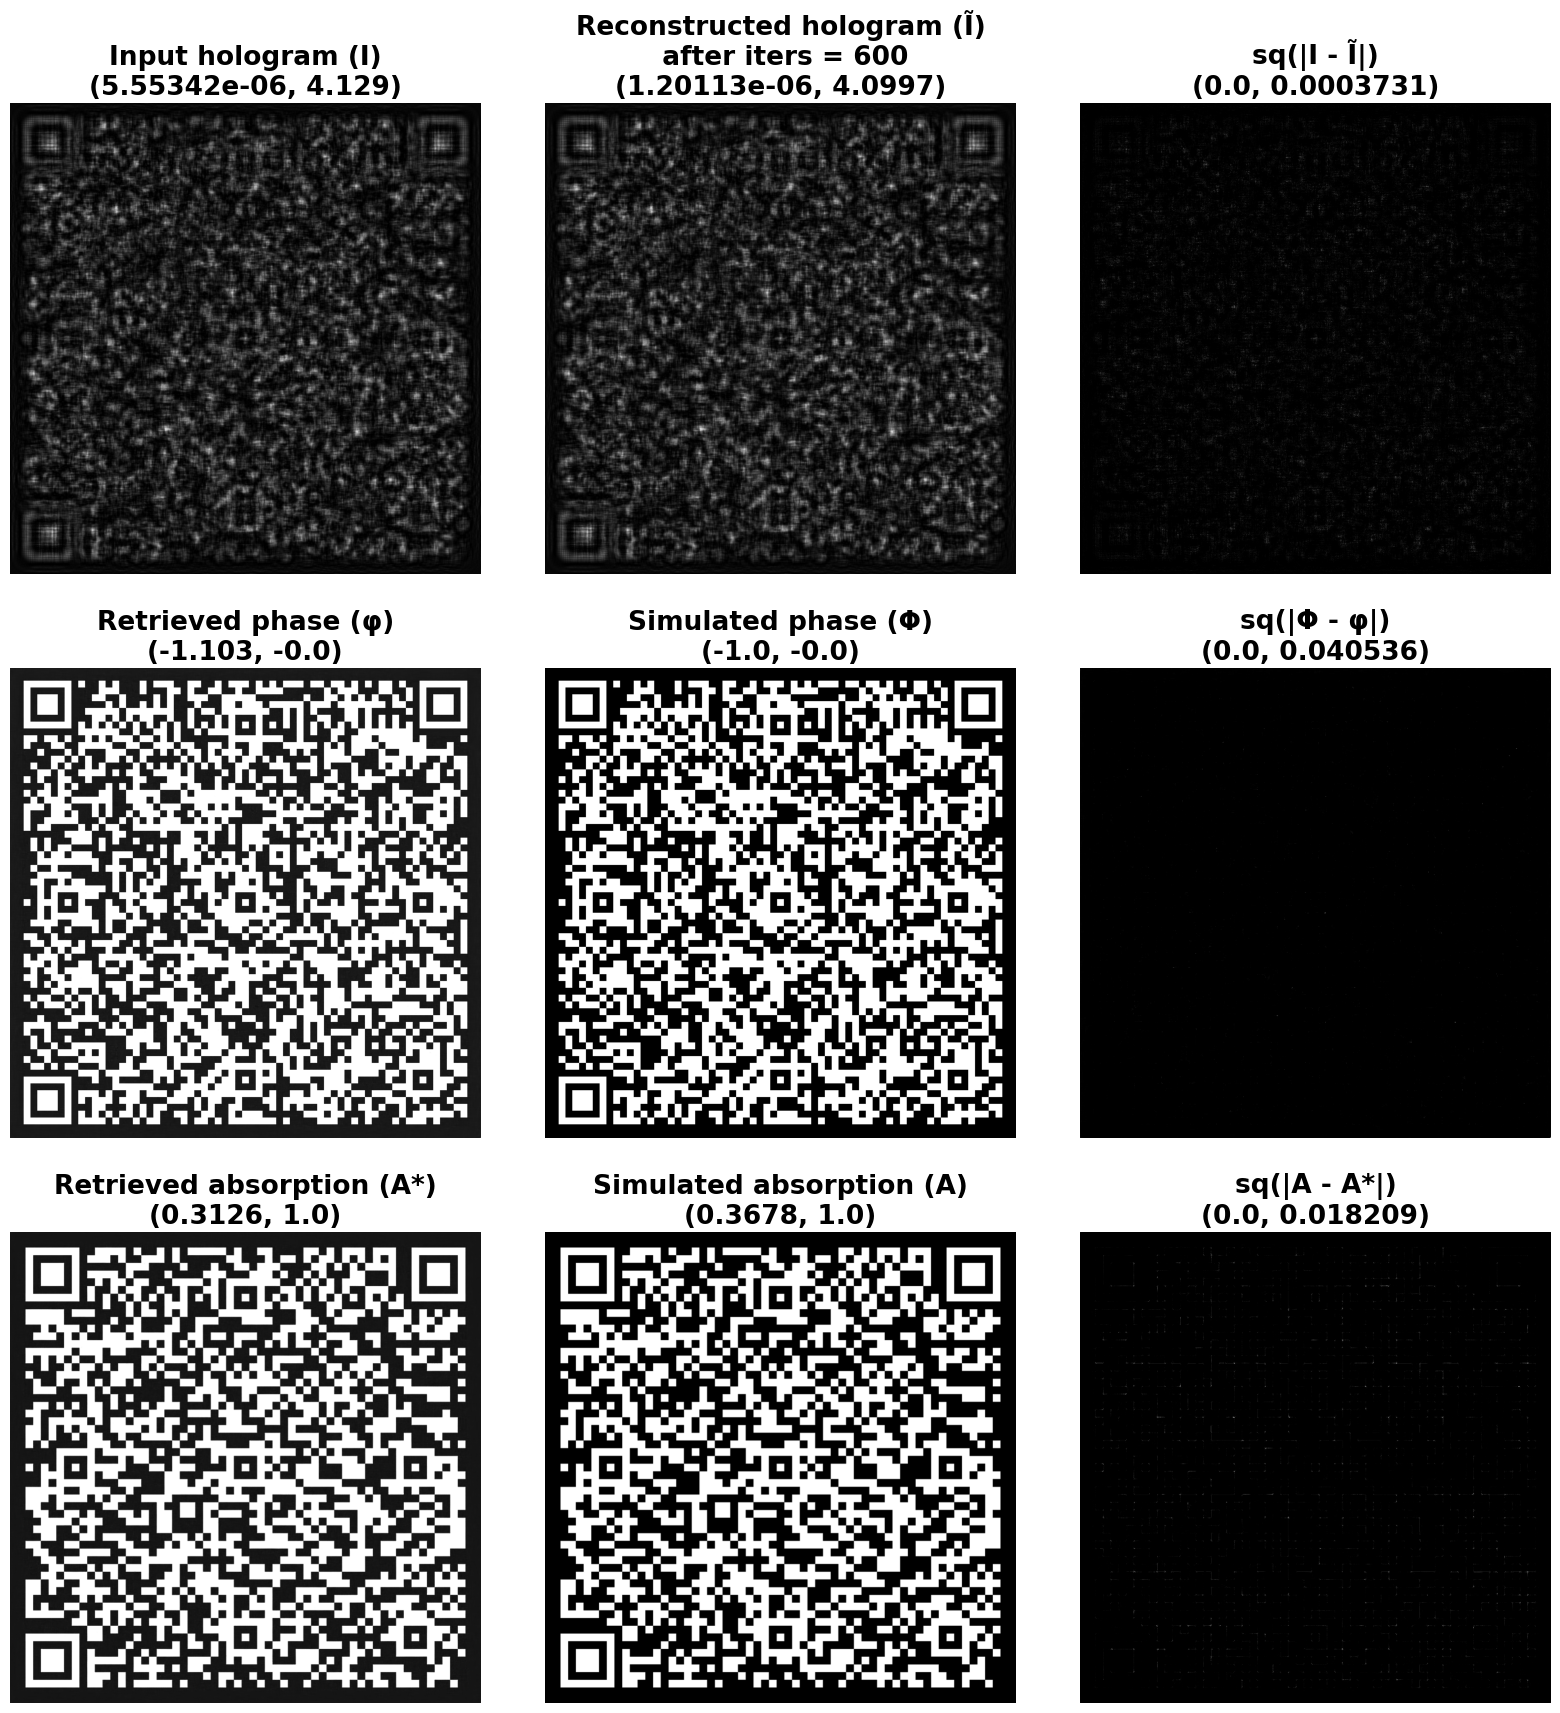

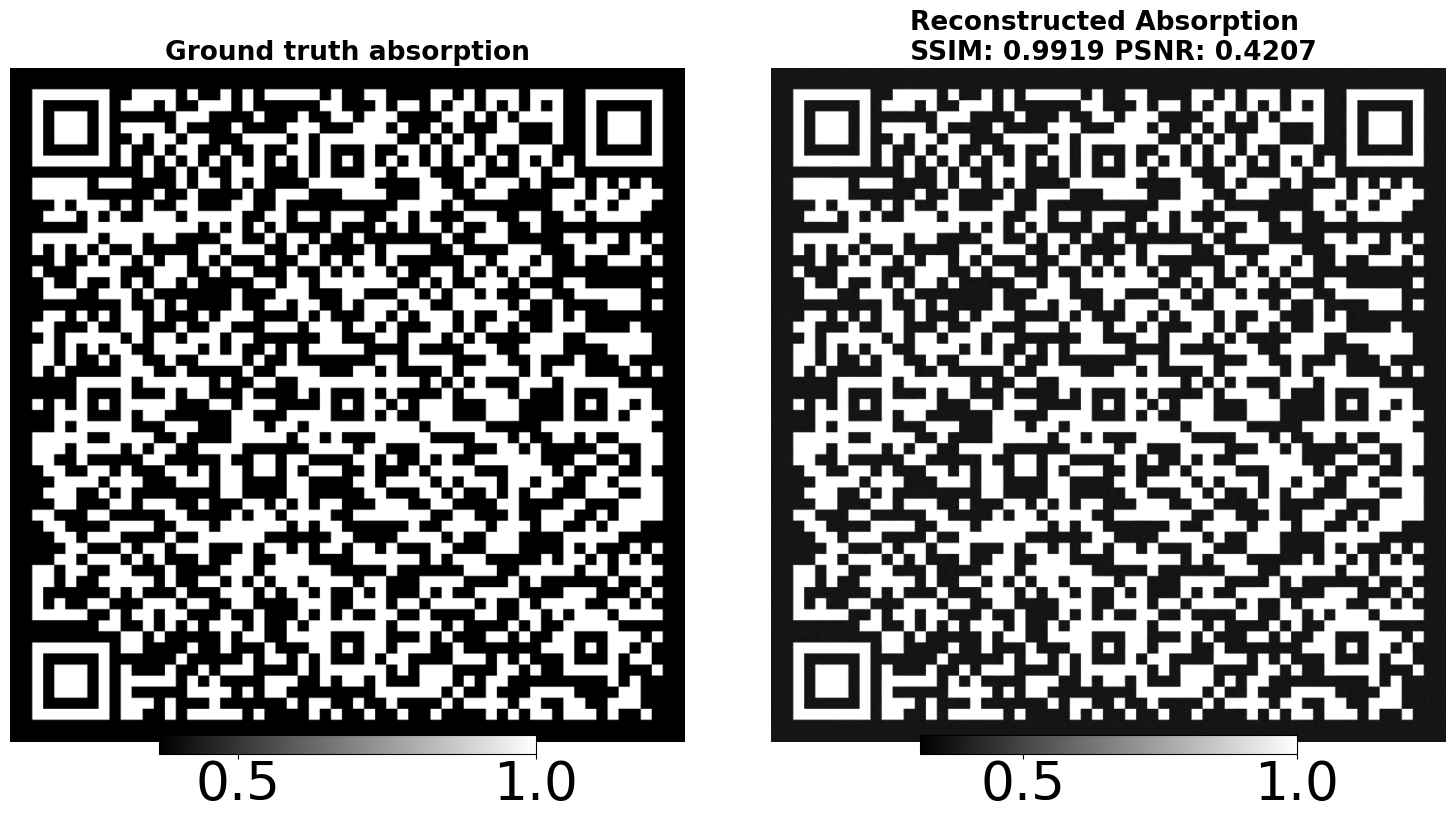

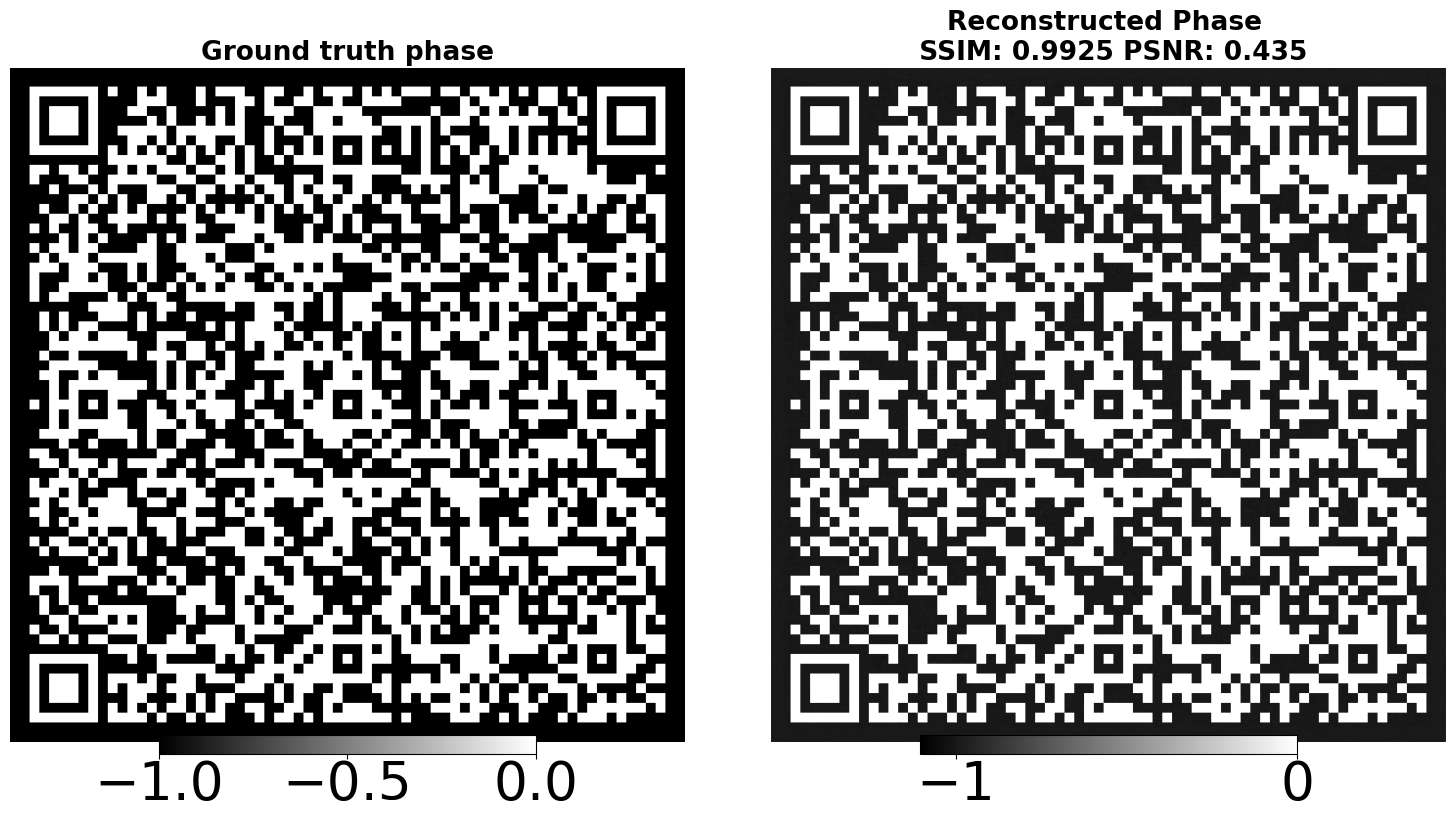

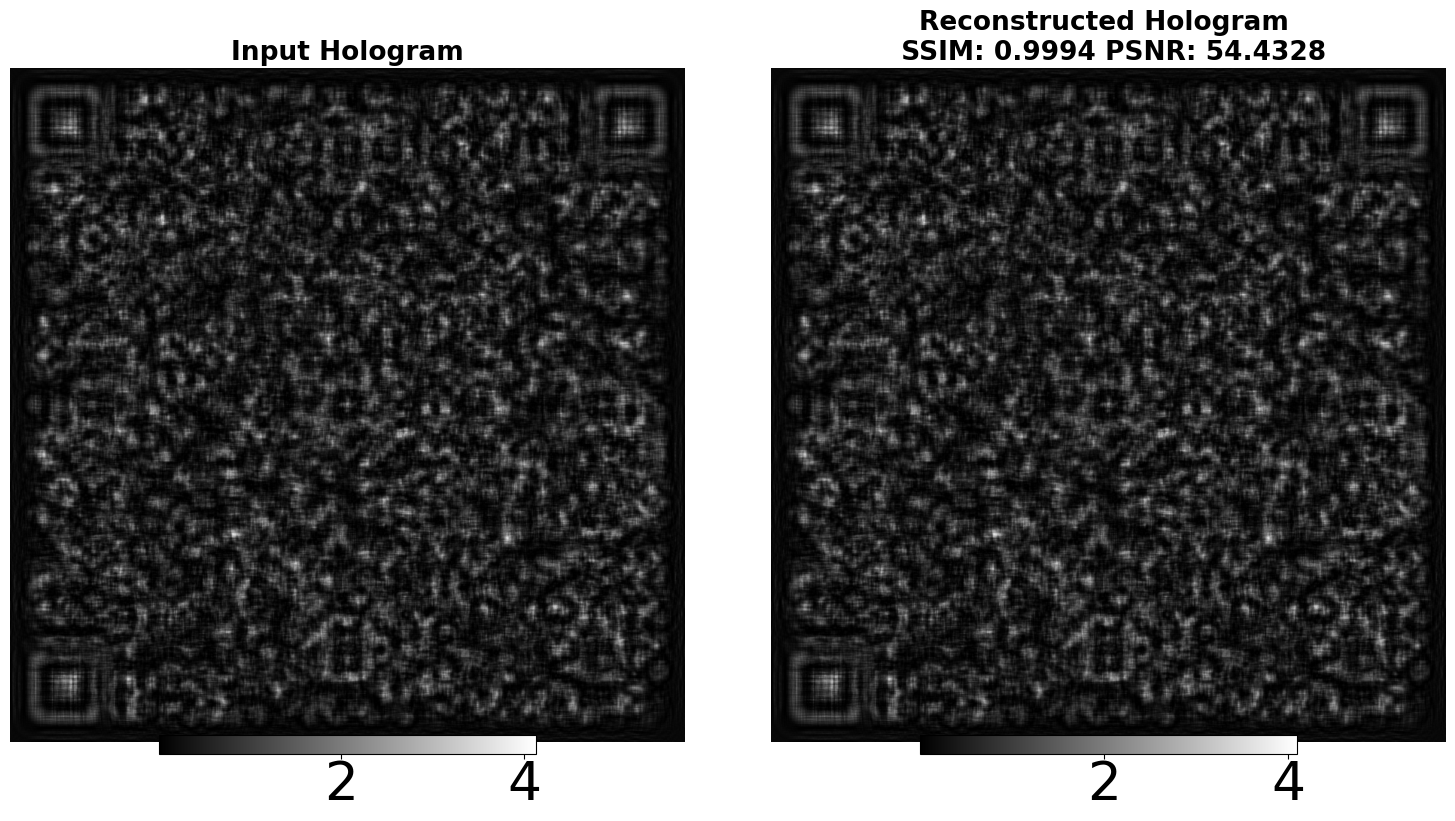

Stage 897  LR  score: 100%|██████████| 600/600 [03:59<00:00,  2.50it/s, psnr=52.789, ssim=0.999]


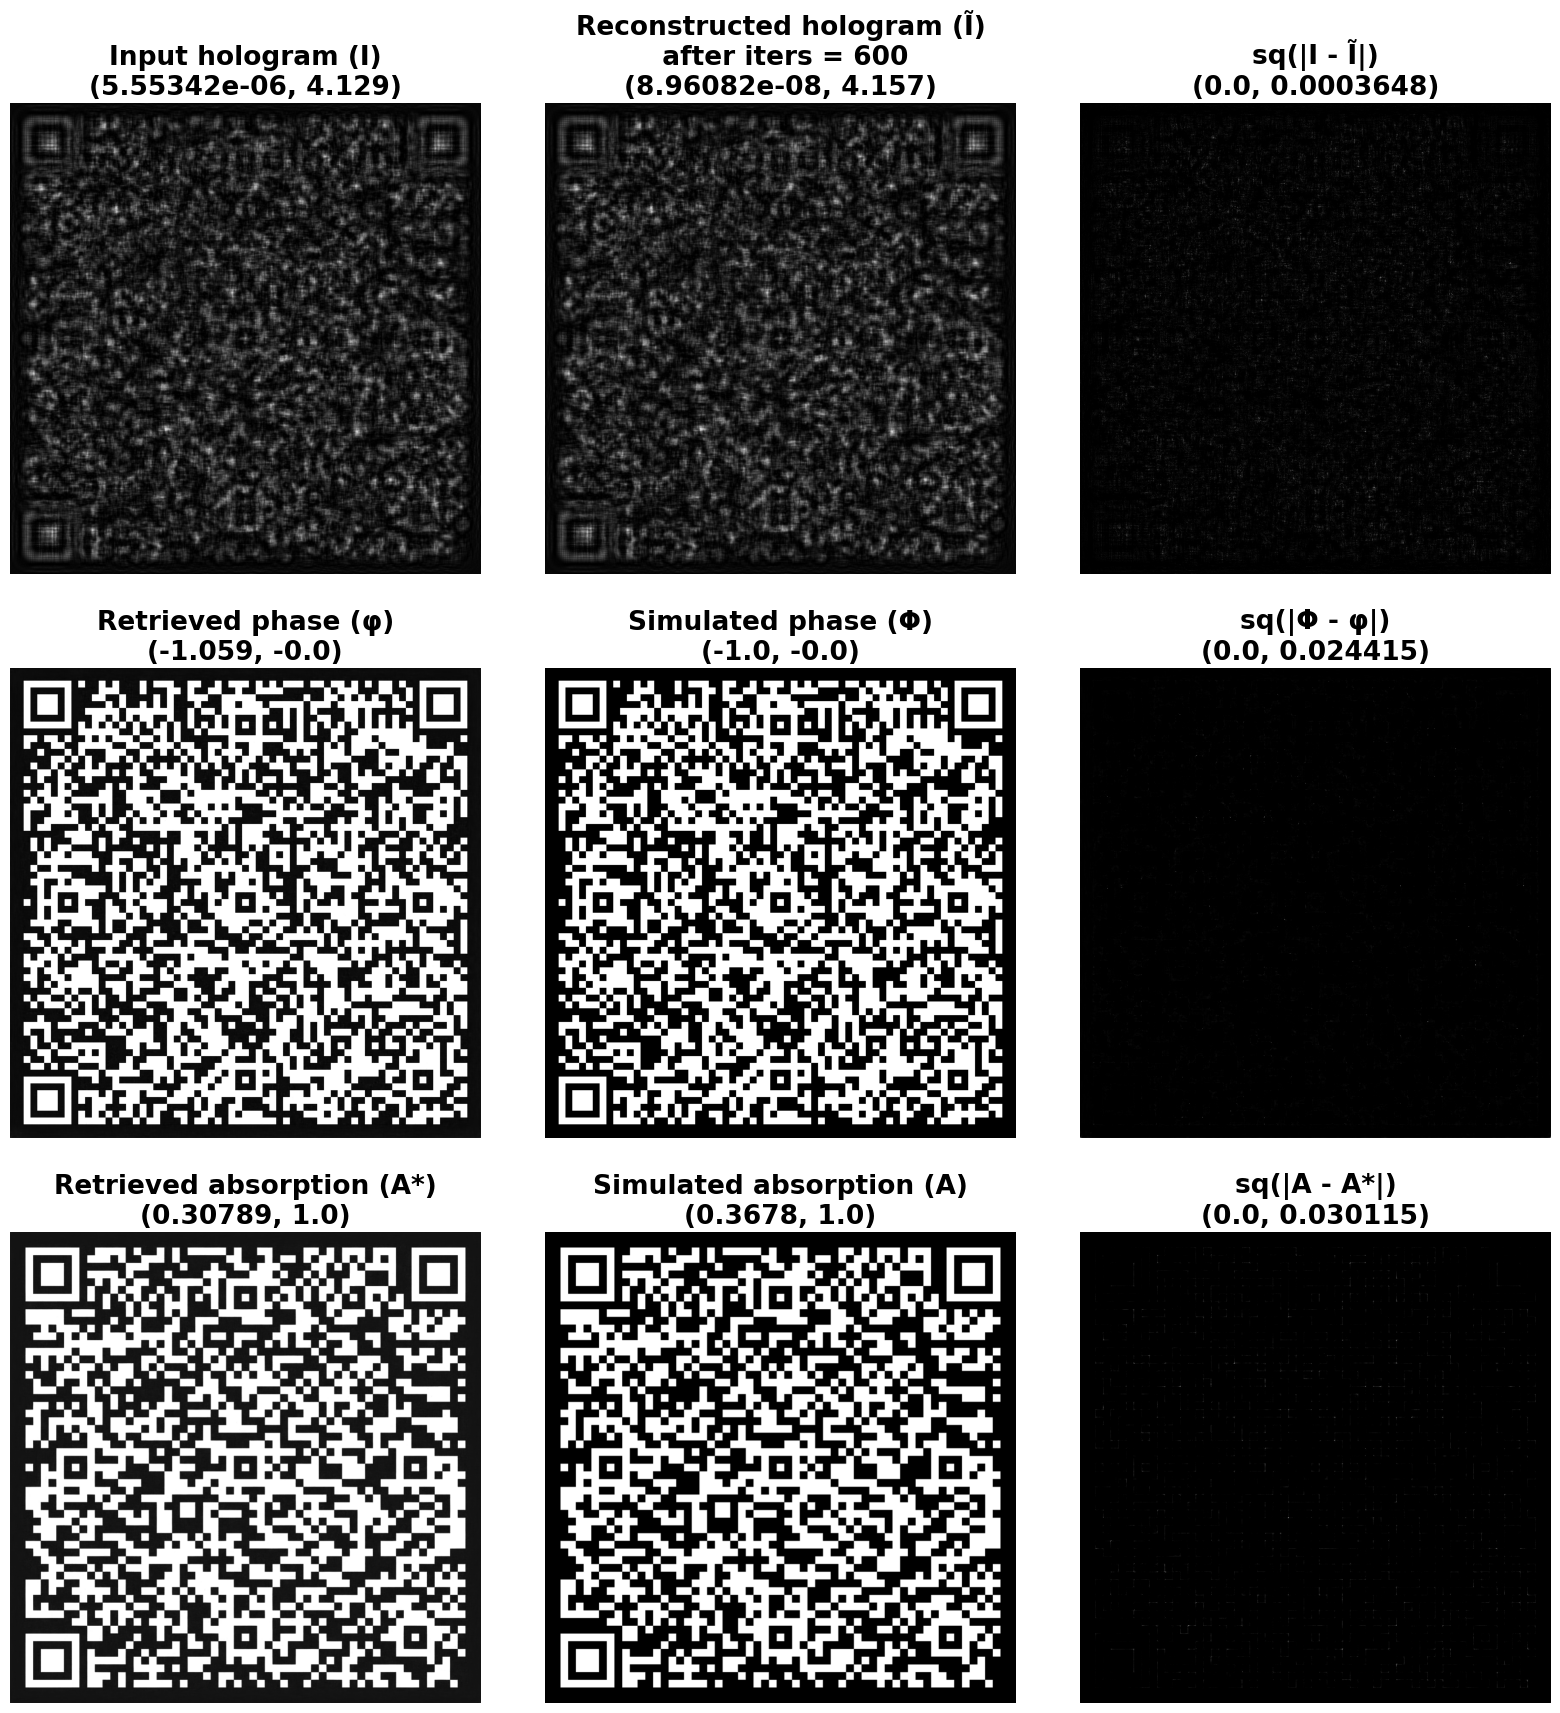

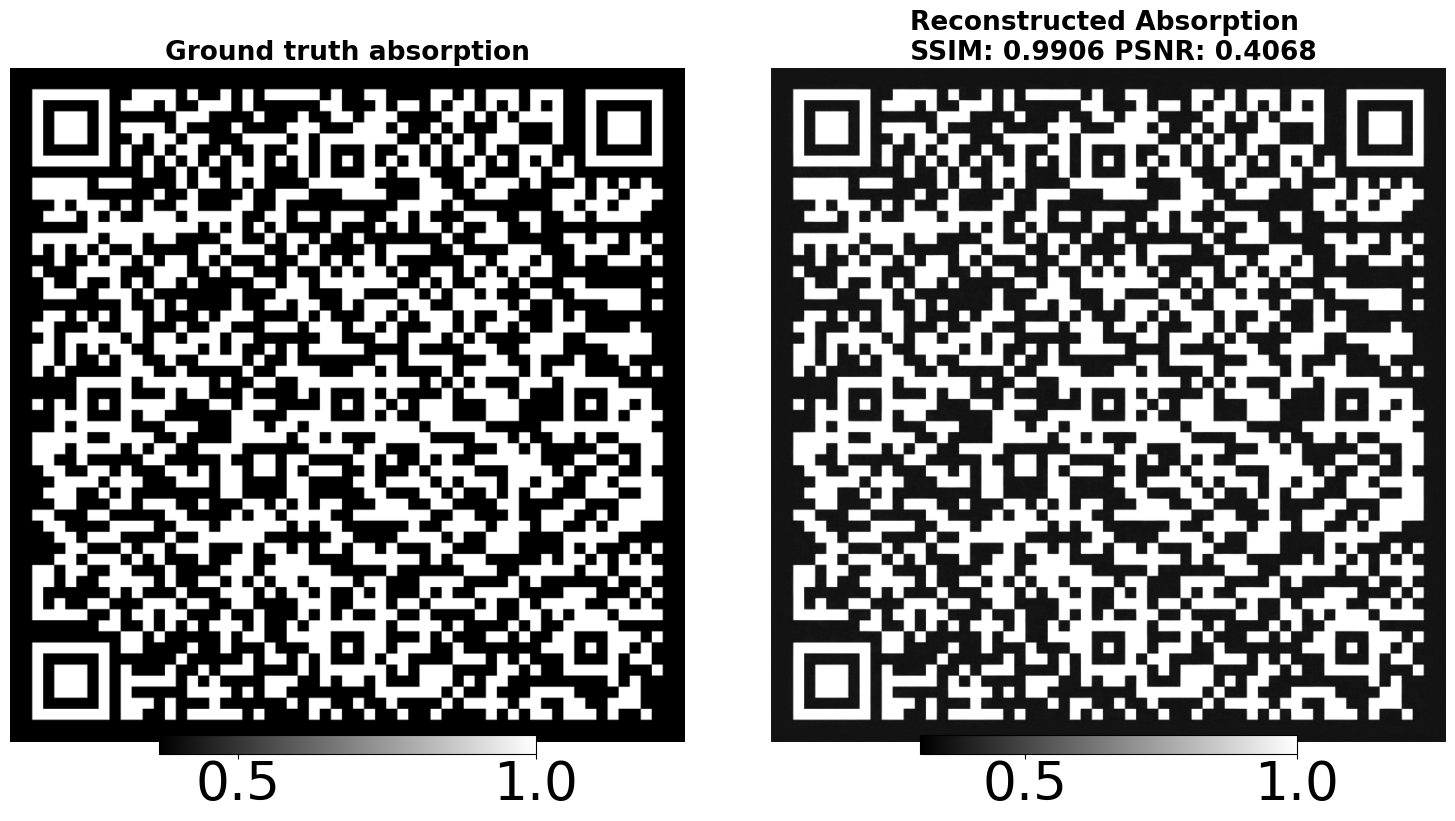

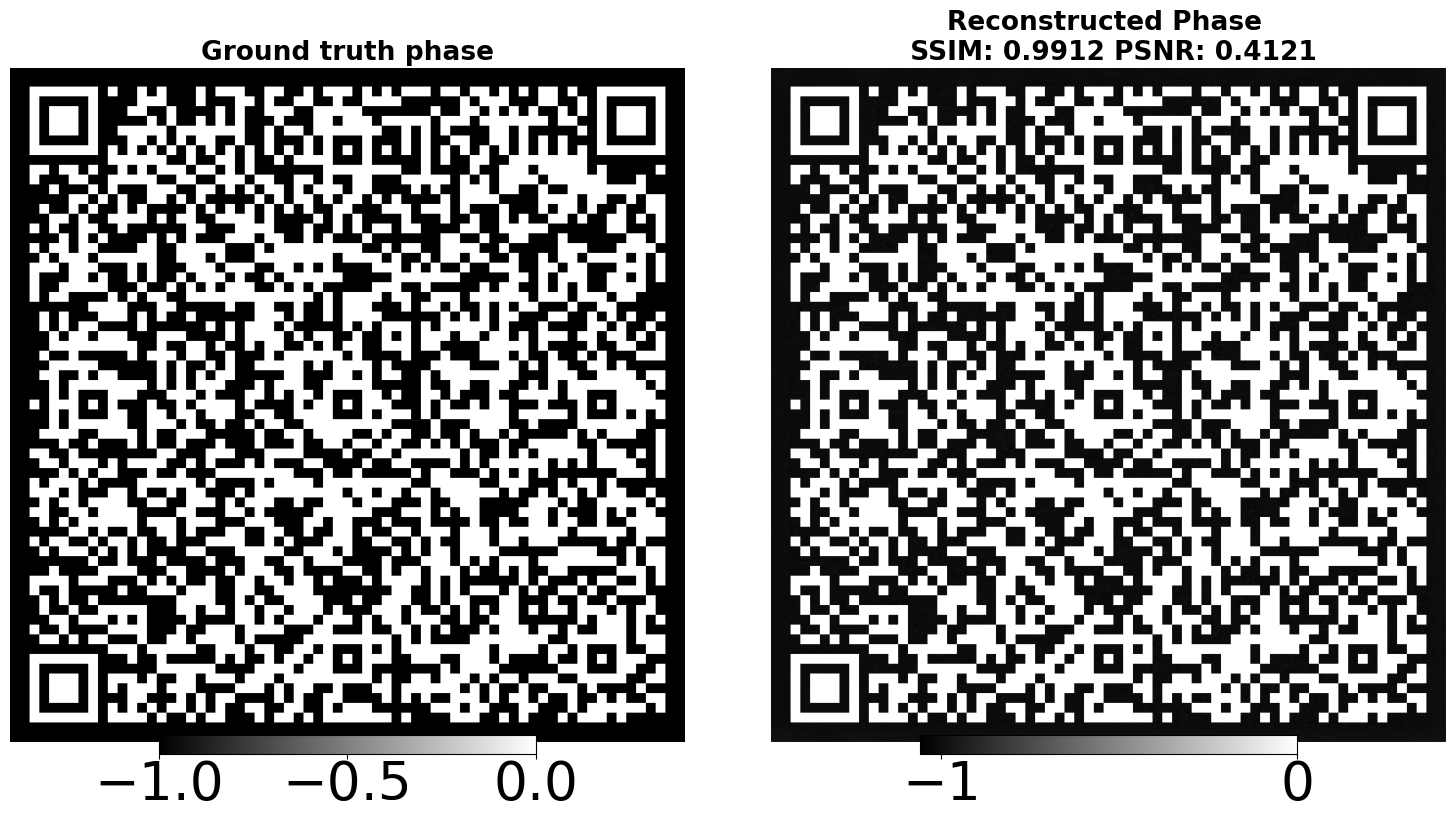

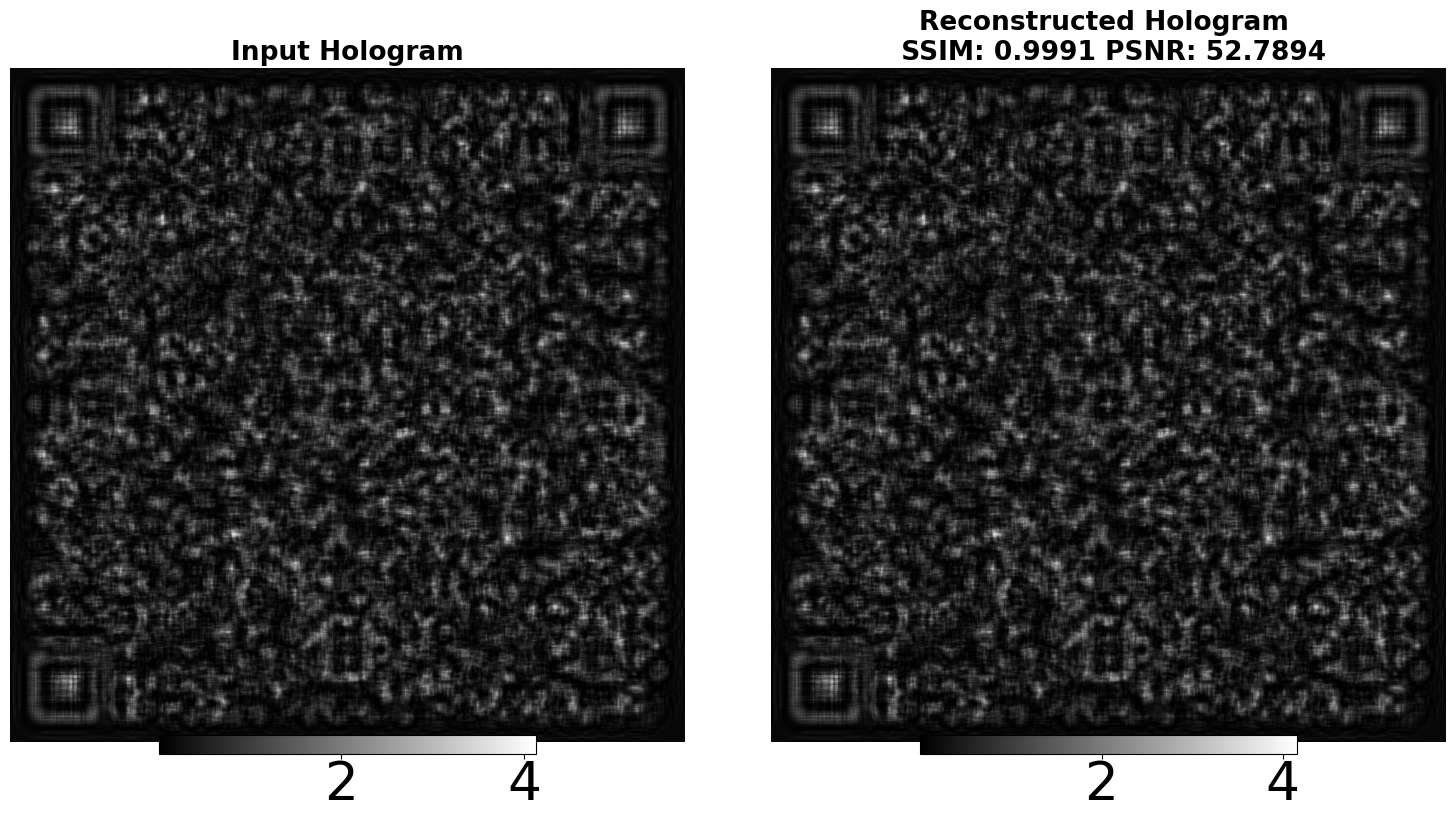

In [1]:
from libraries.available_experiments import *
# Example usage
image_path = 'data/qr/'
qr_data = [
    ("Phase (V20|BS10|B4): A Good Phase: Solving the Near-field Phase Retrieval Inverse Problem Quantitatively Using Selfphish. Phase retrieval is a non-linear, ill-posed inverse problem that is essential for accurate wavefront reconstruction prior to tomographic analysis. Selfphish enables quantitative phase retrieval with high precision.", image_path + 'phase_qr_code.tif'),
    ("Absorbance: Experimental results demonstrate Selfphish’s superior accuracy and robustness across diverse imaging scenarios. underscoring its potential to significantly enhance phase retrieval and image quality in X-ray imaging and beyond.", image_path + 'abs_qr_code.tif')
]

qr_images = [generate_qr_code(data, path, 10) for data, path in qr_data]

fresnel_prop = propagate_others(
    phase=qr_images[0],
    attenuation=qr_images[1],
    fresnel_number=10**(-2.5),
    task='learn_phase',
    dsf=2**0,
    iter_num=1000,
    positive_attenuation='relu',
    positive_phase='relu_inverted',
    transformation_type='ssim',
    abs_ratio=1,
    model_type='wavelet',
    wavelet='db1',
    init_model=False,
    save_model_path=image_path,
    save_model=True,
    device='cuda:0',
    add_noise=False,
    noise_factor=0.01,
    noise_type='gaussian',
    dis_type='unet',
    dis_depth=2,
)


comparison = []
model_configs = [
    {'task': 'learn_phase', 'init_model': False, 'model_type': 'wavelet'},
    {'task': 'learn_phase', 'init_model': False, 'model_type': 'unet'}
]
vis_config = {'cmap': 'gray', 'vmode': 'show', 'min_max': False, 'colorbar': True, 'colorbar_locaiton': 'bottom', 'zoomout_location': 'bottom right', 'position': 'left', 'axis': 'off', 'axin_axis': 'off'}

for config in model_configs:
    fresnel_prop.update(config)
    model = make_ganrec_model(**fresnel_prop)
    model.train(iter_num=600)
    model.visualize(mode='show', cmap='gray', plot_axis='half', images_per_row=3, sa_hspace=-0.35)

    visualize(
        [model.ground_attenuation, model.attenuation],
        title=[
            'Ground truth absorption',
            f'Reconstructed Absorption \n SSIM: {round(model.ground_att_ssim_list[-1].item(), 4)} PSNR: {round(model.ground_att_psnr_list[-1].item(), 4)}'
        ], **vis_config)

    visualize(
        [model.ground_truth, model.phase],
        title=[
            'Ground truth phase',
            f'Reconstructed Phase \n SSIM: {round(model.ground_ssim_list[-1].item(), 4)} PSNR: {round(model.ground_psnr_list[-1].item(), 4)}'
        ],**vis_config)

    visualize(
        [model.transformed_images, model.propagated_intensity],
        title=[
            'Input Hologram',
            f'Reconstructed Hologram \n SSIM: {round(model.ssim_list[-1].item(), 4)} PSNR: {round(model.psnr_list[-1].item(), 4)}'
        ],**vis_config)

    comparison.append([
        model.ssim_list,
        model.ground_ssim_list,
        model.ground_att_ssim_list,
        model.psnr_list,
        model.ground_psnr_list,
        model.ground_att_psnr_list
    ])

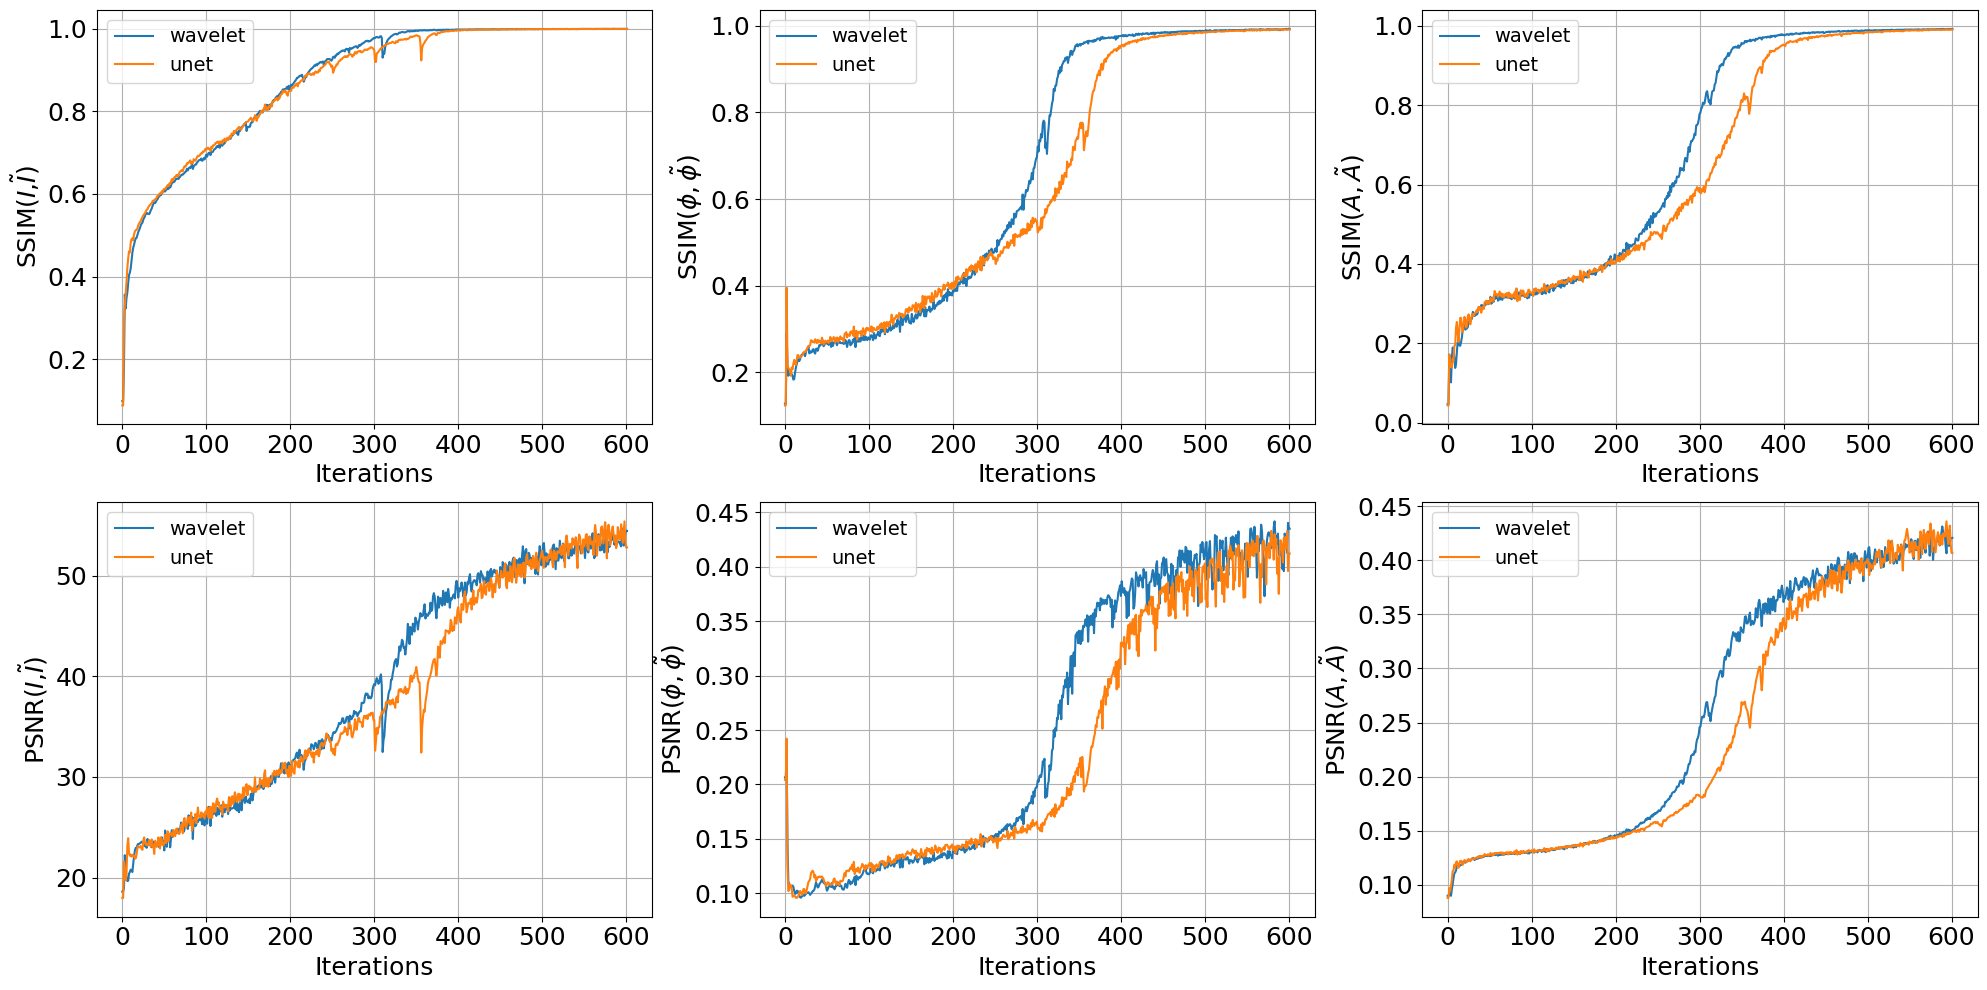

In [2]:
import matplotlib.pyplot as plt

keys = ['SSIM(${I}$,$\\tilde{I}$)', 'SSIM($\\phi,\\tilde{\\phi}$)', 'SSIM($A,\\tilde{A}$)', 'PSNR(${I}$,$\\tilde{I}$)', 'PSNR($\\phi,\\tilde{\\phi}$)', 'PSNR($A,\\tilde{A}$)']

fig, ax = plt.subplots(2, 3, figsize=(20, 10))
rows, cols = 2, 3
for i in range(2):
    for j in range(3):
        ax[i, j].plot(comparison[0][i*cols+j], label='wavelet')
        ax[i, j].plot(comparison[1][i*cols+j], label='unet')
        ax[i, j].legend(prop={'size': 14})
        # ax[i, j].set_title(keys[i*cols+j], fontsize=20)
        ax[i, j].set_xlabel('Iterations', fontsize=18)
        ax[i, j].set_ylabel(keys[i*cols+j], fontsize=18)
        ax[i, j].grid()
        ax[i, j].tick_params(axis='both', which='major', labelsize=18)
plt.tight_layout()
plt.show()


In [3]:
phase_list = resize_with_diff_interpolation(model.phase_list, (256, 256))
att_list = resize_with_diff_interpolation(model.attenuation_list, (256, 256))

create_gif_with_progress_profile_text([phase_list[i] for i in range(100,300)], 'data/images/qr_phase.gif', duration = 5.5, loop = 0, add_profile = False)
create_gif_with_progress_profile_text([att_list[i] for i in range(100,300)], 'data/images/qr_att.gif', duration = 5.5, loop = 0, add_profile = False)

In [16]:
(att_list[0].shape)

(128, 128)